In [1]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
!nvidia-smi

Sat Nov  2 10:14:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P400                    Off | 00000000:2D:00.0  On |                  N/A |
| 34%   36C    P8              N/A /  N/A |    102MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from torch_geometric.nn import RGCNConv

from sklearn.metrics import roc_auc_score

2024-11-02 10:14:44.279647: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 10:14:44.327387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 10:14:45.008006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Load graph
view=1
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/home/mayank/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [5]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [6]:
# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [7]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [8]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

In [9]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [10]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 2365462  Test:675846  Validation: 337922


In [11]:
## EXTERNAL TEST SETS

## VIEW 0-2
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [12]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 12], [True, 16900]]


In [13]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def encode(self, x, edge_index, edge_type):
        edge_type = edge_type.view(-1)
        x = self.conv1(x, edge_index, edge_type).relu()
        return self.conv2(x, edge_index, edge_type)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [14]:
num_relations = len(pred_mapping)
model = Net(train_data.num_features, 8, 4, num_relations).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [15]:
loader = LinkNeighborLoader(
    train_data,
    num_neighbors=[30] * 2,
    batch_size=8,
)

/home/mayank/.local/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [16]:
def train():
    model.train()
    optimizer.zero_grad()

    # Flatten edge_type to make sure it's 1D
    edge_type = train_data.edge_type.view(-1)  # Ensure it's 1D

    z = model.encode(train_data.x, train_data.edge_index, edge_type)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()


In [17]:
@torch.no_grad()
def test(data):
    model.eval()
    edge_type = data.edge_type.view(-1)  # Ensure edge_type is 1D

    z = model.encode(data.x, data.edge_index, edge_type)

    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


In [18]:
@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index, data.edge_type)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()

    # Ensure edge_type is 1D
    edge_type = data.edge_type.view(-1)  # Flatten edge_type to be 1D if necessary

    # Check edge_index dimensions
    if data.edge_index.dim() != 2 or data.edge_index.size(0) != 2:
        raise ValueError(f"Expected edge_index with shape [2, num_edges], but got {data.edge_index.shape}")

    z = model.encode(data.x, data.edge_index, data.edge_type)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

In [19]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 266.2578
Epoch: 002, Loss: 234.4258
Epoch: 003, Loss: 205.6067
Epoch: 004, Loss: 179.9693
Epoch: 005, Loss: 156.8114
Epoch: 006, Loss: 136.5651
Epoch: 007, Loss: 118.9183
Epoch: 008, Loss: 103.3990
Epoch: 009, Loss: 89.6361
Epoch: 010, Loss: 77.6777
Epoch: 011, Loss: 67.5194
Epoch: 012, Loss: 58.9436
Epoch: 013, Loss: 51.5232
Epoch: 014, Loss: 45.3891
Epoch: 015, Loss: 40.1859
Epoch: 016, Loss: 35.8089
Epoch: 017, Loss: 32.3672
Epoch: 018, Loss: 29.1654
Epoch: 019, Loss: 26.6586
Epoch: 020, Loss: 25.2745
Epoch: 021, Loss: 24.1674
Epoch: 022, Loss: 23.2025
Epoch: 023, Loss: 22.2916
Epoch: 024, Loss: 21.4235


In [20]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 20.6198
Epoch: 002, Loss: 19.8335
Epoch: 003, Loss: 19.0930
Epoch: 004, Loss: 18.3075
Epoch: 005, Loss: 17.5062
Epoch: 006, Loss: 16.7636
Epoch: 007, Loss: 15.9888
Epoch: 008, Loss: 15.2586
Epoch: 009, Loss: 14.5203
Epoch: 010, Loss: 13.7946
Epoch: 011, Loss: 13.1146
Epoch: 012, Loss: 12.4393
Epoch: 013, Loss: 11.8107
Epoch: 014, Loss: 11.2463
Epoch: 015, Loss: 10.7266
Epoch: 016, Loss: 10.2134
Epoch: 017, Loss: 9.7256
Epoch: 018, Loss: 9.2320
Epoch: 019, Loss: 8.8309
Epoch: 020, Loss: 8.4284
Epoch: 021, Loss: 8.0877
Epoch: 022, Loss: 7.7747
Epoch: 023, Loss: 7.4931
Epoch: 024, Loss: 7.2458
Epoch: 025, Loss: 6.9972
Epoch: 026, Loss: 6.7862
Epoch: 027, Loss: 6.5816
Epoch: 028, Loss: 6.3777
Epoch: 029, Loss: 6.1944
Epoch: 030, Loss: 6.0171
Epoch: 031, Loss: 5.8376
Epoch: 032, Loss: 5.6553
Epoch: 033, Loss: 5.4545
Epoch: 034, Loss: 5.2703
Epoch: 035, Loss: 5.0771
Epoch: 036, Loss: 4.8995
Epoch: 037, Loss: 4.7268
Epoch: 038, Loss: 4.5617
Epoch: 039, Loss: 4.4054
Epoch: 04

In [21]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 3.3314
Epoch: 002, Loss: 3.2388
Epoch: 003, Loss: 3.1651
Epoch: 004, Loss: 3.0900
Epoch: 005, Loss: 3.0102
Epoch: 006, Loss: 2.9366
Epoch: 007, Loss: 2.8764
Epoch: 008, Loss: 2.8162
Epoch: 009, Loss: 2.7568
Epoch: 010, Loss: 2.7054
Epoch: 011, Loss: 2.6590
Epoch: 012, Loss: 2.6149
Epoch: 013, Loss: 2.5696
Epoch: 014, Loss: 2.5214
Epoch: 015, Loss: 2.4737
Epoch: 016, Loss: 2.4332
Epoch: 017, Loss: 2.3899
Epoch: 018, Loss: 2.3475
Epoch: 019, Loss: 2.3062
Epoch: 020, Loss: 2.2678
Epoch: 021, Loss: 2.2312
Epoch: 022, Loss: 2.1913
Epoch: 023, Loss: 2.1537
Epoch: 024, Loss: 2.1198


In [22]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 2.0858
Epoch: 002, Loss: 2.0570
Epoch: 003, Loss: 2.0178
Epoch: 004, Loss: 1.9900
Epoch: 005, Loss: 1.9575
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.8988
Epoch: 008, Loss: 1.8719
Epoch: 009, Loss: 1.8425
Epoch: 010, Loss: 1.8183
Epoch: 011, Loss: 1.7904
Epoch: 012, Loss: 1.7691
Epoch: 013, Loss: 1.7434
Epoch: 014, Loss: 1.7195
Epoch: 015, Loss: 1.6942
Epoch: 016, Loss: 1.6750
Epoch: 017, Loss: 1.6508
Epoch: 018, Loss: 1.6298
Epoch: 019, Loss: 1.6103
Epoch: 020, Loss: 1.5894
Epoch: 021, Loss: 1.5673
Epoch: 022, Loss: 1.5489
Epoch: 023, Loss: 1.5307
Epoch: 024, Loss: 1.5130
Epoch: 025, Loss: 1.4944
Epoch: 026, Loss: 1.4795
Epoch: 027, Loss: 1.4621
Epoch: 028, Loss: 1.4437
Epoch: 029, Loss: 1.4270
Epoch: 030, Loss: 1.4128
Epoch: 031, Loss: 1.3987
Epoch: 032, Loss: 1.3818
Epoch: 033, Loss: 1.3681
Epoch: 034, Loss: 1.3522
Epoch: 035, Loss: 1.3398
Epoch: 036, Loss: 1.3240
Epoch: 037, Loss: 1.3118
Epoch: 038, Loss: 1.2986
Epoch: 039, Loss: 1.2892
Epoch: 040, Loss: 1.2735


In [23]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 1.1680
Epoch: 002, Loss: 1.1595
Epoch: 003, Loss: 1.1482
Epoch: 004, Loss: 1.1425
Epoch: 005, Loss: 1.1324
Epoch: 006, Loss: 1.1242
Epoch: 007, Loss: 1.1161
Epoch: 008, Loss: 1.1077
Epoch: 009, Loss: 1.1004
Epoch: 010, Loss: 1.0933
Epoch: 011, Loss: 1.0862
Epoch: 012, Loss: 1.0776
Epoch: 013, Loss: 1.0704
Epoch: 014, Loss: 1.0652
Epoch: 015, Loss: 1.0577
Epoch: 016, Loss: 1.0517
Epoch: 017, Loss: 1.0453
Epoch: 018, Loss: 1.0382
Epoch: 019, Loss: 1.0328
Epoch: 020, Loss: 1.0280
Epoch: 021, Loss: 1.0214
Epoch: 022, Loss: 1.0148
Epoch: 023, Loss: 1.0091
Epoch: 024, Loss: 1.0040
Epoch: 025, Loss: 0.9996
Epoch: 026, Loss: 0.9924
Epoch: 027, Loss: 0.9883
Epoch: 028, Loss: 0.9822
Epoch: 029, Loss: 0.9791
Epoch: 030, Loss: 0.9720
Epoch: 031, Loss: 0.9697
Epoch: 032, Loss: 0.9630
Epoch: 033, Loss: 0.9590
Epoch: 034, Loss: 0.9551
Epoch: 035, Loss: 0.9509
Epoch: 036, Loss: 0.9472
Epoch: 037, Loss: 0.9424
Epoch: 038, Loss: 0.9385
Epoch: 039, Loss: 0.9339
Epoch: 040, Loss: 0.9304


In [24]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.8949
Epoch: 002, Loss: 0.8927
Epoch: 003, Loss: 0.8883
Epoch: 004, Loss: 0.8867
Epoch: 005, Loss: 0.8833
Epoch: 006, Loss: 0.8806
Epoch: 007, Loss: 0.8769
Epoch: 008, Loss: 0.8738
Epoch: 009, Loss: 0.8719
Epoch: 010, Loss: 0.8697
Epoch: 011, Loss: 0.8652
Epoch: 012, Loss: 0.8641
Epoch: 013, Loss: 0.8626
Epoch: 014, Loss: 0.8592
Epoch: 015, Loss: 0.8562
Epoch: 016, Loss: 0.8539
Epoch: 017, Loss: 0.8532
Epoch: 018, Loss: 0.8495
Epoch: 019, Loss: 0.8469
Epoch: 020, Loss: 0.8452
Epoch: 021, Loss: 0.8430
Epoch: 022, Loss: 0.8412
Epoch: 023, Loss: 0.8381
Epoch: 024, Loss: 0.8364
Epoch: 025, Loss: 0.8341
Epoch: 026, Loss: 0.8326
Epoch: 027, Loss: 0.8295
Epoch: 028, Loss: 0.8280
Epoch: 029, Loss: 0.8265
Epoch: 030, Loss: 0.8239
Epoch: 031, Loss: 0.8230
Epoch: 032, Loss: 0.8207
Epoch: 033, Loss: 0.8192
Epoch: 034, Loss: 0.8169
Epoch: 035, Loss: 0.8151
Epoch: 036, Loss: 0.8135
Epoch: 037, Loss: 0.8117
Epoch: 038, Loss: 0.8096
Epoch: 039, Loss: 0.8082
Epoch: 040, Loss: 0.8078


In [25]:
# Training
n_epochs=51

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.7914
Epoch: 002, Loss: 0.7906
Epoch: 003, Loss: 0.7886
Epoch: 004, Loss: 0.7878
Epoch: 005, Loss: 0.7858
Epoch: 006, Loss: 0.7849
Epoch: 007, Loss: 0.7837
Epoch: 008, Loss: 0.7827
Epoch: 009, Loss: 0.7814
Epoch: 010, Loss: 0.7792
Epoch: 011, Loss: 0.7788
Epoch: 012, Loss: 0.7782
Epoch: 013, Loss: 0.7755
Epoch: 014, Loss: 0.7752
Epoch: 015, Loss: 0.7741
Epoch: 016, Loss: 0.7732
Epoch: 017, Loss: 0.7716
Epoch: 018, Loss: 0.7712
Epoch: 019, Loss: 0.7686
Epoch: 020, Loss: 0.7688
Epoch: 021, Loss: 0.7673
Epoch: 022, Loss: 0.7662
Epoch: 023, Loss: 0.7646
Epoch: 024, Loss: 0.7633
Epoch: 025, Loss: 0.7632
Epoch: 026, Loss: 0.7618
Epoch: 027, Loss: 0.7602
Epoch: 028, Loss: 0.7596
Epoch: 029, Loss: 0.7589
Epoch: 030, Loss: 0.7575
Epoch: 031, Loss: 0.7565
Epoch: 032, Loss: 0.7564
Epoch: 033, Loss: 0.7547
Epoch: 034, Loss: 0.7545
Epoch: 035, Loss: 0.7536
Epoch: 036, Loss: 0.7523
Epoch: 037, Loss: 0.7510
Epoch: 038, Loss: 0.7502
Epoch: 039, Loss: 0.7488
Epoch: 040, Loss: 0.7480


In [27]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.7221
Epoch: 002, Loss: 0.7216
Epoch: 003, Loss: 0.7210
Epoch: 004, Loss: 0.7211
Epoch: 005, Loss: 0.7199
Epoch: 006, Loss: 0.7196
Epoch: 007, Loss: 0.7189
Epoch: 008, Loss: 0.7179
Epoch: 009, Loss: 0.7173
Epoch: 010, Loss: 0.7169
Epoch: 011, Loss: 0.7163
Epoch: 012, Loss: 0.7154
Epoch: 013, Loss: 0.7154
Epoch: 014, Loss: 0.7146
Epoch: 015, Loss: 0.7142
Epoch: 016, Loss: 0.7134
Epoch: 017, Loss: 0.7132
Epoch: 018, Loss: 0.7122
Epoch: 019, Loss: 0.7116
Epoch: 020, Loss: 0.7113
Epoch: 021, Loss: 0.7114
Epoch: 022, Loss: 0.7108
Epoch: 023, Loss: 0.7093
Epoch: 024, Loss: 0.7090


In [29]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')

 View: 1, Train: 0.910757633807221, Val: 0.9103


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [28]:
z = get_emb(train_data)

In [22]:
z

array([[-2.4492722 , -0.6552468 ,  0.9055247 , ...,  1.8216192 ,
        -0.99422055,  0.29060993],
       [ 4.0754585 ,  1.341559  ,  0.3342143 , ...,  7.1238008 ,
        -2.3000321 ,  3.1685843 ],
       [-0.9524948 , -0.25481823,  0.35214856, ...,  0.70840746,
        -0.38664138,  0.11301501],
       ...,
       [-4.5052934 ,  4.3372364 , -2.184599  , ...,  1.3943007 ,
        -2.50614   , -4.467516  ],
       [-4.1716666 ,  4.1711636 , -2.013428  , ...,  1.6520531 ,
        -2.373043  , -4.018281  ],
       [-4.0963297 ,  4.133663  , -1.974775  , ...,  1.7102553 ,
        -2.342991  , -3.9168413 ]], dtype=float32)

In [29]:
y= nodes_df['type'].astype('category').cat.codes

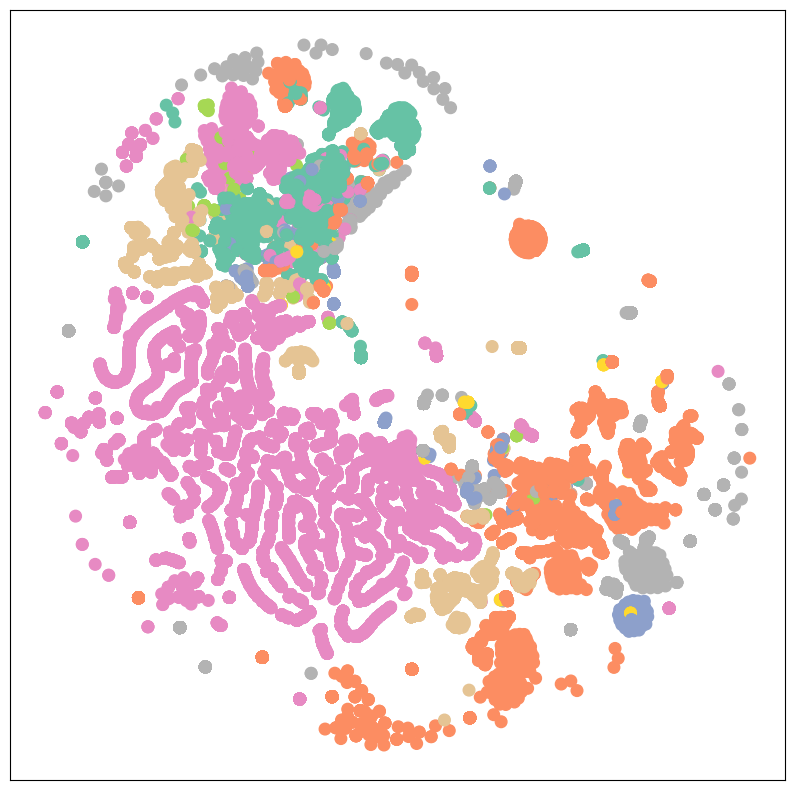

In [24]:
visualize(z,y)

<ipython-input-29-33f9d704249d>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


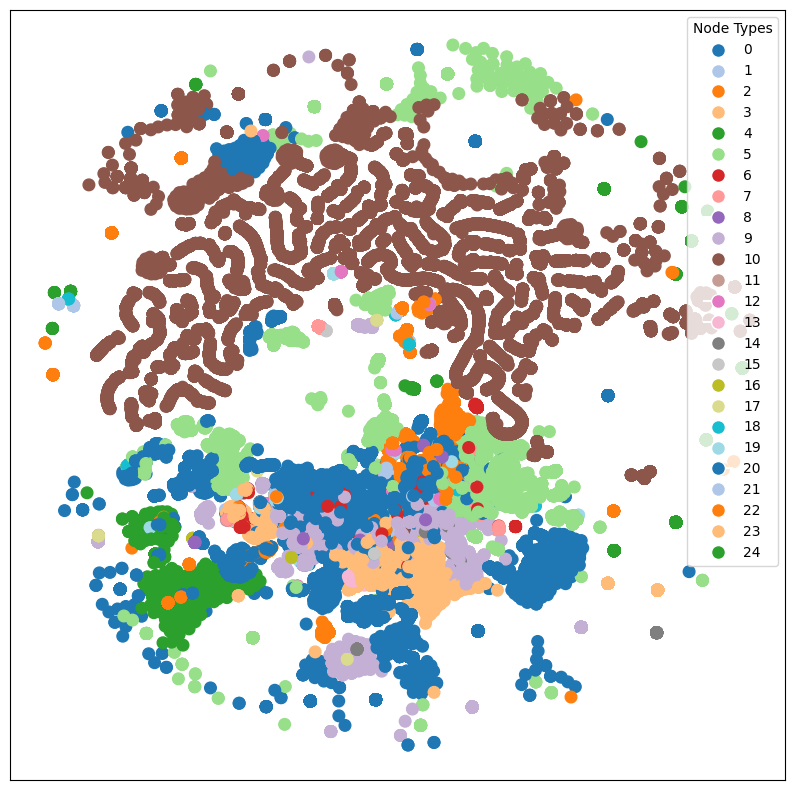

In [ ]:
visualize(z,y)

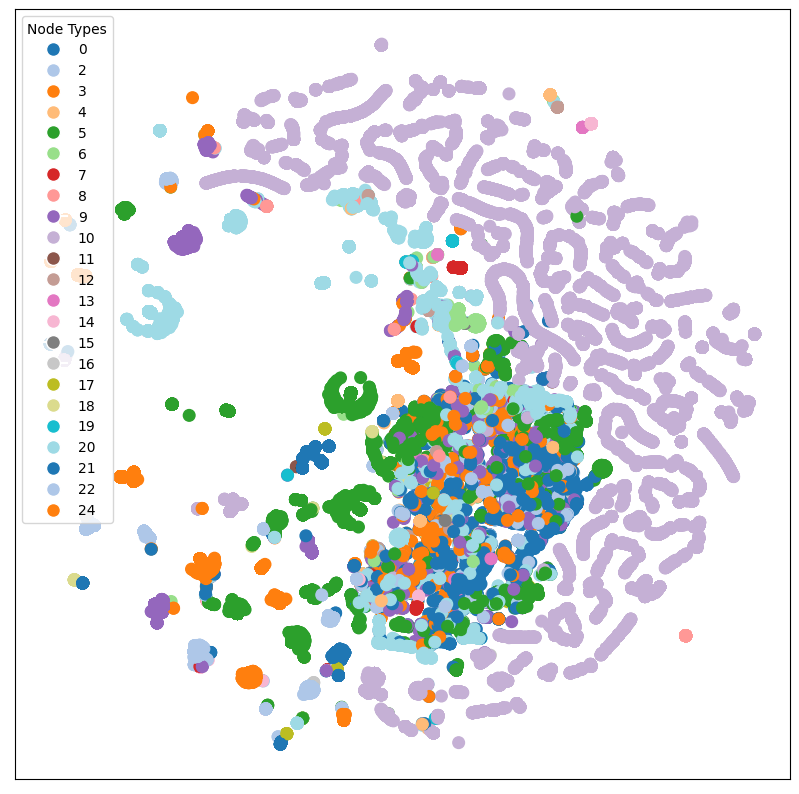

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

def visualize(h, node_types, min_samples=5):
    # Count the frequency of each node type
    unique, counts = np.unique(node_types, return_counts=True)
    node_type_counts = dict(zip(unique, counts))

    # Filter out node types with fewer than the threshold
    common_node_types = [node_type for node_type, count in node_type_counts.items() if count >= min_samples]

    # Filter the data to include only the common node types
    mask = np.isin(node_types, common_node_types)
    h_filtered = h[mask]
    node_types_filtered = np.array(node_types)[mask]

    # Apply t-SNE to reduce dimensionality to 2D
    z = TSNE(n_components=2).fit_transform(h_filtered)

    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    # Get the unique node types in the filtered data
    unique_node_types = np.unique(node_types_filtered)

    # Create a color palette for the node types
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types_filtered]

    # Scatter plot
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors)

    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10)
               for i in range(len(unique_node_types))]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

# Example usage:
# Assuming `get_emb(train_data)` provides the embeddings and `nodes_df['type']` provides the node types
z = get_emb(train_data)
y = nodes_df['type'].astype('category').cat.codes
visualize(z, y, min_samples=5)



In [33]:
torch.save(model, view_path+'RGCNConv_model_view'+str(view)+'.pth')

In [35]:
import os

# Define the directory and file path
view =1
view_path = f'/home/mayank/VIEW{view}/'
predictions_path = os.path.join(view_path, 'predictions')
file_path = os.path.join(predictions_path, f'view{view}_GNN_node_embeddingsrgcn.csv')

# Ensure the directory exists
os.makedirs(predictions_path, exist_ok=True)

In [36]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
probs.to_csv(view_path+'predictions/view'+str(view)+'_GNN_node_embeddings.csv')

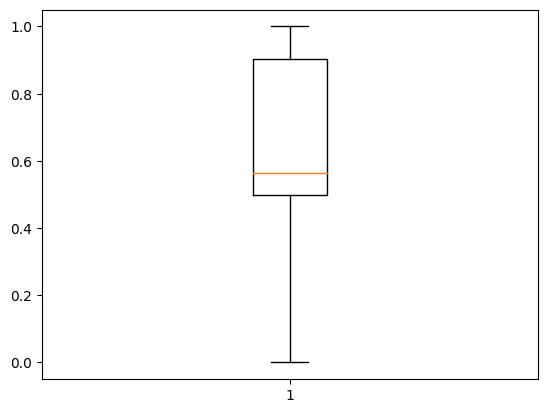

In [37]:
_=plt.boxplot(get_prob(test_data))

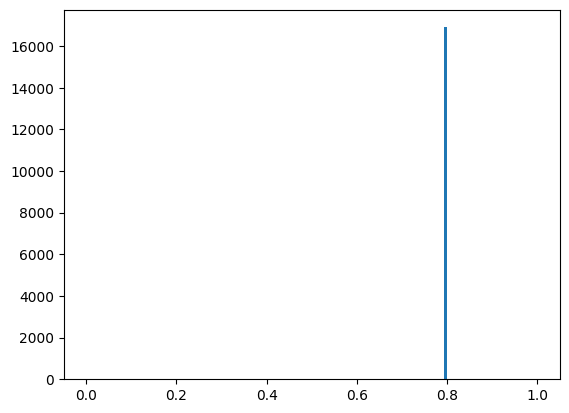

In [38]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [ ]:
nodes_df

,name,type
0,<http://purl.obolibrary.org/obo/MONDO_0007247>,Disease
1,<https://www.mirbase.org/mature/MIMAT0015042>,miRNA
2,<http://purl.obolibrary.org/obo/UBERON_0002195>,Anatomy
3,<http://purl.obolibrary.org/obo/MONDO_0004583>,Disease
4,<http://purl.obolibrary.org/obo/GO_0060761>,GO
...,...,...
85059,<http://purl.obolibrary.org/obo/MONDO_0010781>,Disease
85060,<http://purl.obolibrary.org/obo/HP_0100454>,Phenotype
85061,<http://www.ncbi.nlm.nih.gov/gene/57101>,Gene
85062,<http://www.ncbi.nlm.nih.gov/gene/51316>,Gene


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = z
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9907
Precision: 0.9910
Recall: 0.9907


In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

selected_classes = ['miRNA', 'Gene', 'Disease']

filtered_embeddings = []
filtered_labels = []


for class_label in selected_classes:

    class_indices = nodes_df[nodes_df['type'] == class_label].index


    class_embeddings = z[class_indices, 1:]  # Skip the first column with identifiers

    # Append the filtered embeddings and labels
    filtered_embeddings.append(class_embeddings)
    filtered_labels.extend([class_label] * len(class_embeddings))


X_filtered = np.vstack(filtered_embeddings)

# Encode the labels
le = LabelEncoder()
y_filtered = le.fit_transform(filtered_labels)  # Convert the labels into numerical form


X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

precision_per_class = precision_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))
recall_per_class = recall_score(y_test, y_pred, average=None, labels=np.unique(y_filtered))

for i, class_label in enumerate(le.classes_):
    if class_label in selected_classes:
        print(f"Class: {class_label}")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")


Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
Class: Disease
  Precision: 0.9993
  Recall: 0.9993
Class: Gene
  Precision: 0.9991
  Recall: 0.9991
Class: miRNA
  Precision: 1.0000
  Recall: 1.0000


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Set the minimum threshold for the number of nodes per class
min_samples = 5

# Count the frequency of each node type
node_type_counts = nodes_df['type'].value_counts()

# Filter out node types with fewer than the threshold
common_node_types = node_type_counts[node_type_counts >= min_samples].index

# Filter the data to keep only the common types
filtered_df = nodes_df[nodes_df['type'].isin(common_node_types)]
X_filtered = z[filtered_df.index]  # Embeddings corresponding to the filtered node types
true_labels_filtered = filtered_df['type']

# Encode the labels
le = LabelEncoder()
y_filtered = le.fit_transform(true_labels_filtered)  # Convert the labels into numerical form

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1-score for each class (node type)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")

# Print the precision, recall, and f1-score for each class
for i, class_label in enumerate(le.classes_):
    print(f"Class: {class_label}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")


Overall Accuracy: 0.9596
Class: Anatomy
  Precision: 0.8099
  Recall: 0.9041
  F1 Score: 0.8544
Class: Cell
  Precision: 0.9446
  Recall: 0.7792
  F1 Score: 0.8540
Class: Chemical
  Precision: 0.7654
  Recall: 0.6923
  F1 Score: 0.7270
Class: Chromosome
  Precision: 0.9677
  Recall: 0.9278
  F1 Score: 0.9474
Class: Disease
  Precision: 0.9804
  Recall: 0.9876
  F1 Score: 0.9840
Class: Environment
  Precision: 0.8879
  Recall: 0.7661
  F1 Score: 0.8225
Class: Environmental exposure
  Precision: 0.9790
  Recall: 0.9790
  F1 Score: 0.9790
Class: Food
  Precision: 1.0000
  Recall: 0.8545
  F1 Score: 0.9216
Class: GO
  Precision: 0.8995
  Recall: 0.8405
  F1 Score: 0.8690
Class: Gene
  Precision: 0.9971
  Recall: 0.9988
  F1 Score: 0.9980
Class: General medical science
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: Genomic feature
  Precision: 1.0000
  Recall: 0.6071
  F1 Score: 0.7556
Class: Human developmental stage
  Precision: 1.0000
  Recall: 0.7895
  F1 Score: 0.8824
C

/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the labels
true_labels = nodes_df['type']
X =  z

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(true_labels)  # Convert the labels into numerical form

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42,  class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1-score for each class (node type)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Print the overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")

for i, class_label in enumerate(le.classes_):
    try:
        print(f"Class: {class_label}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1[i]:.4f}")
    except IndexError:
        print(f"Class: {class_label}")
        print("  Precision: 0.0000 (No predictions for this class)")
        print("  Recall: 0.0000")
        print("  F1 Score: 0.0000")


Overall Accuracy: 0.9602
Class: Anatomy
  Precision: 0.8028
  Recall: 0.9120
  F1 Score: 0.8539
Class: Basic formal
  Precision: 0.9611
  Recall: 0.7965
  F1 Score: 0.8711
Class: Cell
  Precision: 0.7754
  Recall: 0.7172
  F1 Score: 0.7451
Class: Chemical
  Precision: 0.9872
  Recall: 0.8953
  F1 Score: 0.9390
Class: Chromosome
  Precision: 0.9837
  Recall: 0.9863
  F1 Score: 0.9850
Class: Disease
  Precision: 0.8899
  Recall: 0.7293
  F1 Score: 0.8017
Class: Environment
  Precision: 0.9922
  Recall: 0.9697
  F1 Score: 0.9808
Class: Environmental exposure
  Precision: 0.9773
  Recall: 0.8776
  F1 Score: 0.9247
Class: Food
  Precision: 0.9165
  Recall: 0.8425
  F1 Score: 0.8779
Class: GO
  Precision: 0.9971
  Recall: 0.9988
  F1 Score: 0.9980
Class: Gene
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class: General medical science
  Precision: 1.0000
  Recall: 0.6207
  F1 Score: 0.7660
Class: Genomic feature
  Precision: 1.0000
  Recall: 0.7895
  F1 Score: 0.8824
Class: Human d

/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
from grape import Graph
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [31]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [44]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=False,
    enable_cache=False
)

Evaluating on VIEW1_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

In [45]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINEv1rg.csv"
results.to_csv(filename)

In [46]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,miss_rate,accuracy,specificity,markedness,threat_score,fall_out,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.498406,0.504439,0.507284,0.008878,0.336028,0.492716,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.518410,0.494235,0.506880,-0.011537,0.322540,0.493120,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.179322,0.511536,0.202394,0.037350,0.456539,0.797606,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.183980,0.509007,0.201993,0.028915,0.453847,0.798007,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.296367,0.502934,0.302236,0.006996,0.414447,0.697764,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.306230,0.497088,0.300407,-0.006890,0.408197,0.699593,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.271026,0.500542,0.272110,0.001370,0.421887,0.727890,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.280059,0.495901,0.271862,-0.010256,0.416599,0.728138,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.134237,0.507255,0.148746,0.029861,0.467663,0.851254,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.138411,0.505312,0.149034,0.021581,0.465481,0.850966,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


In [32]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

In [33]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[DecisionTreeEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=False
)

Evaluating on VIEW1_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

In [34]:
results = evaluation
filename = "results_"+view_name+"DesicionTree_v1RGCN.csv"
results.to_csv(filename)

In [35]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,accuracy,miss_rate,negative_predictive_value,threat_score,fall_out,prevalence_threshold,...,"(model_parameters, criterion)","(model_parameters, splitter)","(model_parameters, max_depth)","(model_parameters, min_samples_split)","(model_parameters, min_samples_leaf)","(model_parameters, min_weight_fraction_leaf)","(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, ccp_alpha)"
0,train,0.800001,1.0,True,0.494969,0.032343,0.407904,0.489279,0.977718,0.501293,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.496961,0.028663,0.440698,0.491215,0.977415,0.500780,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.501736,0.200409,0.504293,0.445177,0.796119,0.499456,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.501289,0.201381,0.503179,0.444655,0.796042,0.499596,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.488737,0.136254,0.454944,0.457911,0.886272,0.503218,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.488839,0.135815,0.455233,0.458087,0.886506,0.503188,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.500307,0.075319,0.502032,0.480587,0.924066,0.499917,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.501932,0.072579,0.512967,0.482139,0.923556,0.499478,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
0,train,0.800001,1.0,True,0.487691,0.108303,0.435884,0.465318,0.916316,0.503404,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0
1,test,0.800001,1.0,True,0.486984,0.109229,0.432357,0.464717,0.916803,0.503601,...,gini,best,10,2,1,0.0,sqrt,None,0.0,0.0


In [36]:
# Separate train and test results
train_results = evaluation[evaluation['evaluation_mode'] == 'train']
test_results = evaluation[evaluation['evaluation_mode'] == 'test']

# Function to compute mean metrics for a given evaluation mode
def compute_mean_metrics(data):
    results = []
    for holdout in data['holdout_number'].unique():
        holdout_data = data[data['holdout_number'] == holdout]

        # Calculate mean values for metrics
        auc_score = holdout_data['auroc'].mean()
        precision = holdout_data['precision'].mean()
        recall = holdout_data['recall'].mean()
        f1_score = holdout_data['f1_score'].mean()
        accuracy = holdout_data['accuracy'].mean()  # Assuming 'accuracy' column exists

        # Append results for this holdout
        results.append({
            'Holdout': holdout,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Accuracy': accuracy
        })

    # Convert to DataFrame
    return pd.DataFrame(results)

# Compute metrics for train and test
train_metrics_df = compute_mean_metrics(train_results)
test_metrics_df = compute_mean_metrics(test_results)

# Calculate overall mean for train and test
overall_train_mean = train_metrics_df.mean(numeric_only=True)
overall_test_mean = test_metrics_df.mean(numeric_only=True)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Evaluation Mode': ['Train', 'Test'],
    'AUC': [overall_train_mean['AUC'], overall_test_mean['AUC']],
    'Precision': [overall_train_mean['Precision'], overall_test_mean['Precision']],
    'Recall': [overall_train_mean['Recall'], overall_test_mean['Recall']],
    'F1 Score': [overall_train_mean['F1 Score'], overall_test_mean['F1 Score']],
    'Accuracy': [overall_train_mean['Accuracy'], overall_test_mean['Accuracy']]
})

# Display the summary of mean metrics
print(summary_df)

  Evaluation Mode       AUC  Precision    Recall  F1 Score  Accuracy
0           Train  0.495439   0.497085  0.889474  0.637125  0.494688
1            Test  0.505955   0.497343  0.890466  0.637577  0.495201
